## Importing necessary libraries

In [1]:
import os
from pathlib import Path
from typing import Union, List, Literal, Dict, Callable, Tuple

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
!pip install efficientnet_pytorch -q
from efficientnet_pytorch import EfficientNet

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install torch_summary -q
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from collections import defaultdict

In [3]:
train_dir =  "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train"

In [4]:
test_dir =  "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test"

In [5]:
val_dir =  "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val"

In [6]:
from multiprocessing import Pool, cpu_count

def process_file(file):
    return [str(file), file.parent.name]


def load_images(root_dir):
    train_dir = Path(root_dir)
    data = []
    for subdir in train_dir.iterdir():
        if subdir.is_dir():
            files = list(subdir.glob('*.jpeg'))
            
        with Pool(cpu_count()) as pool:
            result = pool.map(process_file, files)
            data.extend(result)


    df = pd.DataFrame(data, columns=['Filepath', 'Class'])
    return df


In [7]:
train_df = load_images(train_dir)
valid_df = load_images(val_dir)
test_df = load_images(test_dir)

In [8]:
train_df['ID_image'] = train_df.apply(lambda row: row['Filepath'].split('/')[-1],axis=1)
valid_df['ID_image'] = valid_df.apply(lambda row: row['Filepath'].split('/')[-1],axis=1)
test_df['ID_image'] = test_df.apply(lambda row: row['Filepath'].split('/')[-1],axis=1)

In [9]:
train_df['ID'] = train_df.apply(lambda row: int(row['ID_image'].split('_')[0]),axis=1)
valid_df['ID'] = valid_df.apply(lambda row: int(row['ID_image'].split('_')[0]),axis=1)
test_df['ID'] = test_df.apply(lambda row: int(row['ID_image'].split('_')[0]),axis=1)

In [10]:
test_df = test_df.sort_values(by=['ID']).reset_index(drop=True)
valid_df = valid_df.sort_values(by=['ID']).reset_index(drop=True)
train_df = train_df.sort_values(by=['ID']).reset_index(drop=True)

In [11]:
train_test_merged = pd.merge(train_df, test_df, on='ID',how='inner')
train_valid_merged = pd.merge(train_df, valid_df, on='ID',how='inner')

In [12]:
merged_df = pd.concat([train_valid_merged, train_test_merged],axis=0)
merged_df = merged_df.sort_values(by=['ID']).reset_index(drop=True)

In [13]:
trainval_df, test_df = train_test_split(merged_df, test_size=0.1)
train_df, val_df = train_test_split(trainval_df, test_size=0.2)

In [14]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

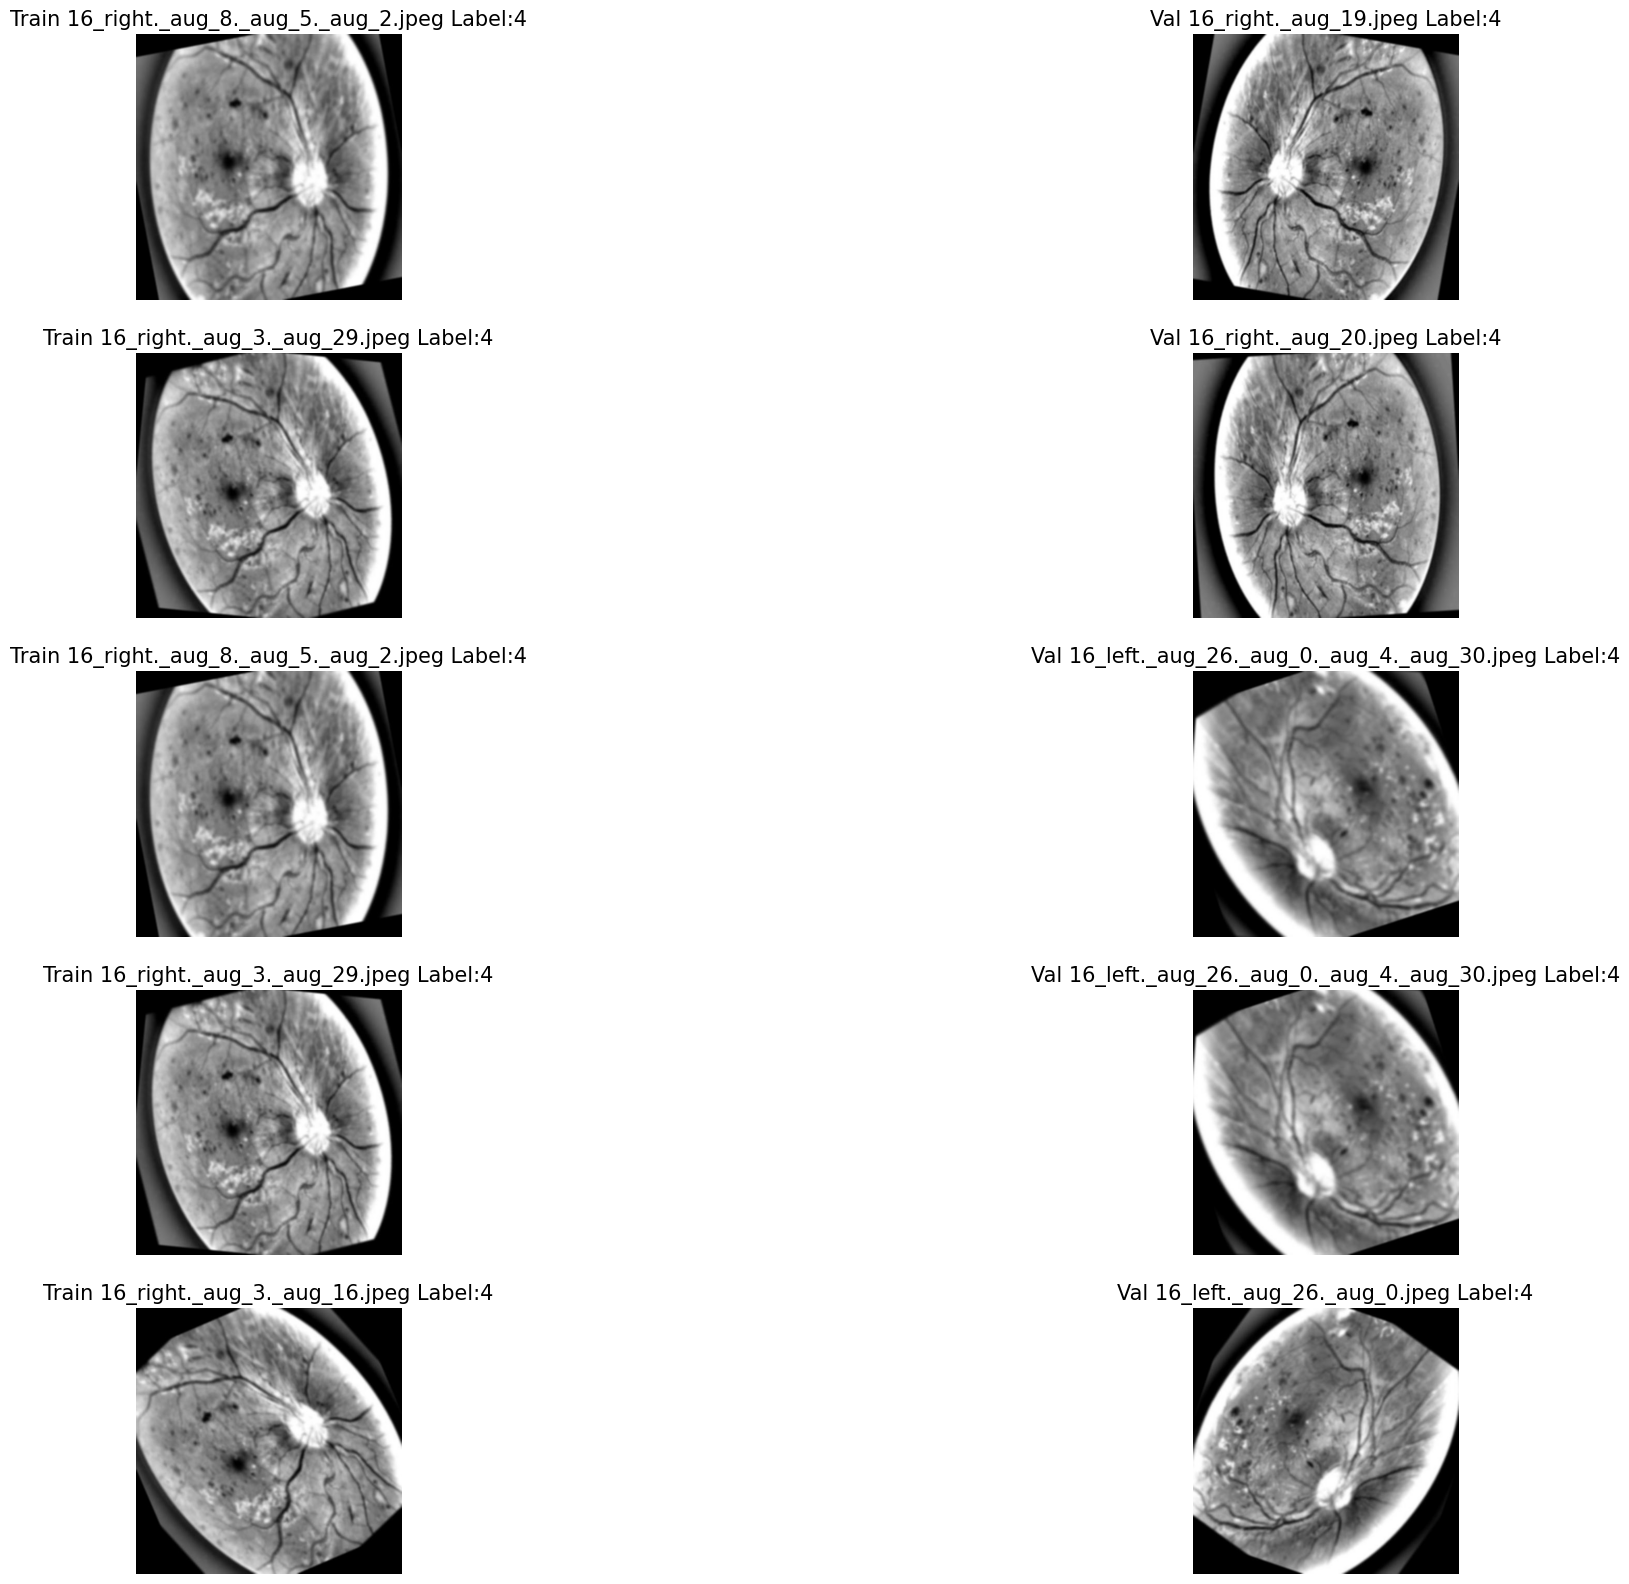

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(25,20))

for i in range(5):
    axs[i,0].imshow(Image.open(merged_df['Filepath_x'][i+200]))
    axs[i,1].imshow(Image.open(merged_df['Filepath_y'][i+200]))
    
    axs[i,0].set_title(f"Train {merged_df['ID_image_x'][i+200]} Label:{merged_df['Class_x'][i+200]}",size=15)
    axs[i,1].set_title(f"Val {merged_df['ID_image_y'][i+200]} Label:{merged_df['Class_y'][i+200]}",size=15)
    
    axs[i,0].axis('off')
    axs[i,1].axis('off')

## Creating a custom dataset

In [16]:
train_transforms = A.Compose(
    [
        A.Resize(width=300, height=300),
        A.RandomCrop(height=225, width=225),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.3),
        A.CLAHE(p=0.3),
        A.ColorJitter(p=0.3),
        A.CoarseDropout(max_holes=12, max_height=20, max_width=20, p=0.3),
        A.Affine(shear=30, rotate=0, p=0.2),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=300, width=300),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

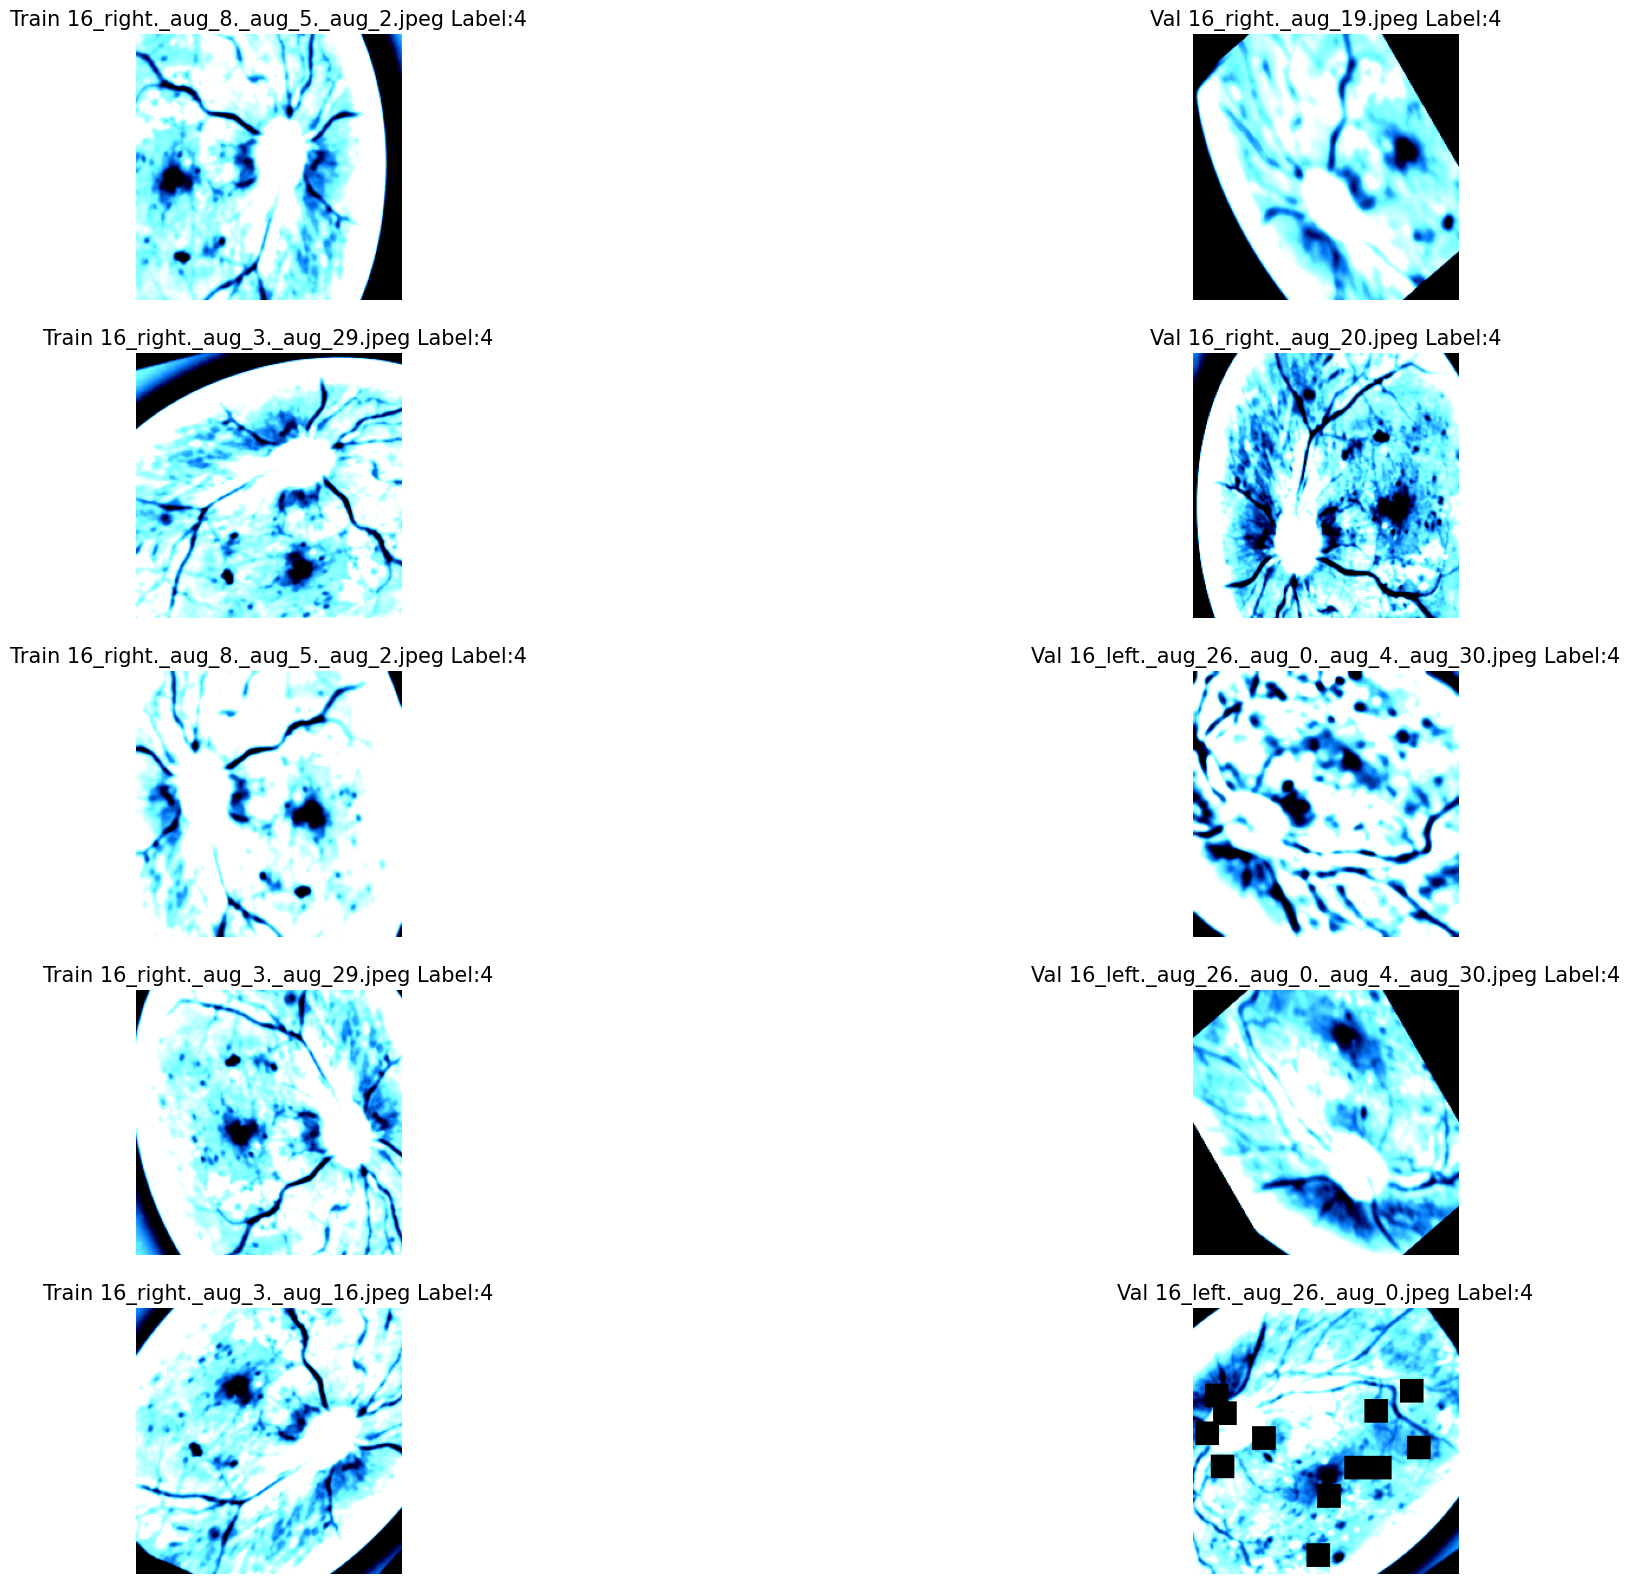

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(25,20))

for i in range(5):
    img1 = train_transforms(image=cv2.imread(merged_df['Filepath_x'][i+200]))
    img2 = train_transforms(image=cv2.imread(merged_df['Filepath_y'][i+200]))
    axs[i,0].imshow(img1['image'].numpy().transpose(1,2,0))
    axs[i,1].imshow(img2['image'].numpy().transpose(1,2,0))
    
    axs[i,0].set_title(f"Train {merged_df['ID_image_x'][i+200]} Label:{merged_df['Class_x'][i+200]}",size=15)
    axs[i,1].set_title(f"Val {merged_df['ID_image_y'][i+200]} Label:{merged_df['Class_y'][i+200]}",size=15)
    
    axs[i,0].axis('off')
    axs[i,1].axis('off')

In [18]:
class CustomDataset(Dataset):
    def __init__(self, data_set : pd.DataFrame, transform = None):
        self.dataset = data_set
        self.transform = transform

    def __len__(self):
        return len(self.dataset['ID'])

    def __getitem__(self, idx):
        dict_data = {}
            
        image_path_1 = self.dataset['Filepath_x'][idx]
        image_path_2 = self.dataset['Filepath_y'][idx]
        image_1 = cv2.imread(image_path_1)
        image_2 = cv2.imread(image_path_2)
        label_1 = self.dataset['Class_x'][idx]
        label_2 = self.dataset['Class_y'][idx]

        if self.transform is not None:
            img1 = self.transform(image=image_1)
            img2 = self.transform(image=image_2)
            dict_data.update({'images':{'img1':img1['image'],'img2':img2['image']}})

        label1_tensor = torch.tensor(float(label_1), dtype=torch.float32)
        label2_tensor = torch.tensor(float(label_2), dtype=torch.float32)
        dict_data.update({'labels': {'label1': label1_tensor, 'label2': label2_tensor}})
        return dict_data

In [19]:
train_dataset = CustomDataset(data_set=train_df, transform=train_transforms)
val_dataset = CustomDataset(data_set=val_df, transform=train_transforms)
test_dataset = CustomDataset(data_set =test_df, transform=val_transforms)

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

#### initializations

In [21]:
dact = next(iter(val_dataloader))

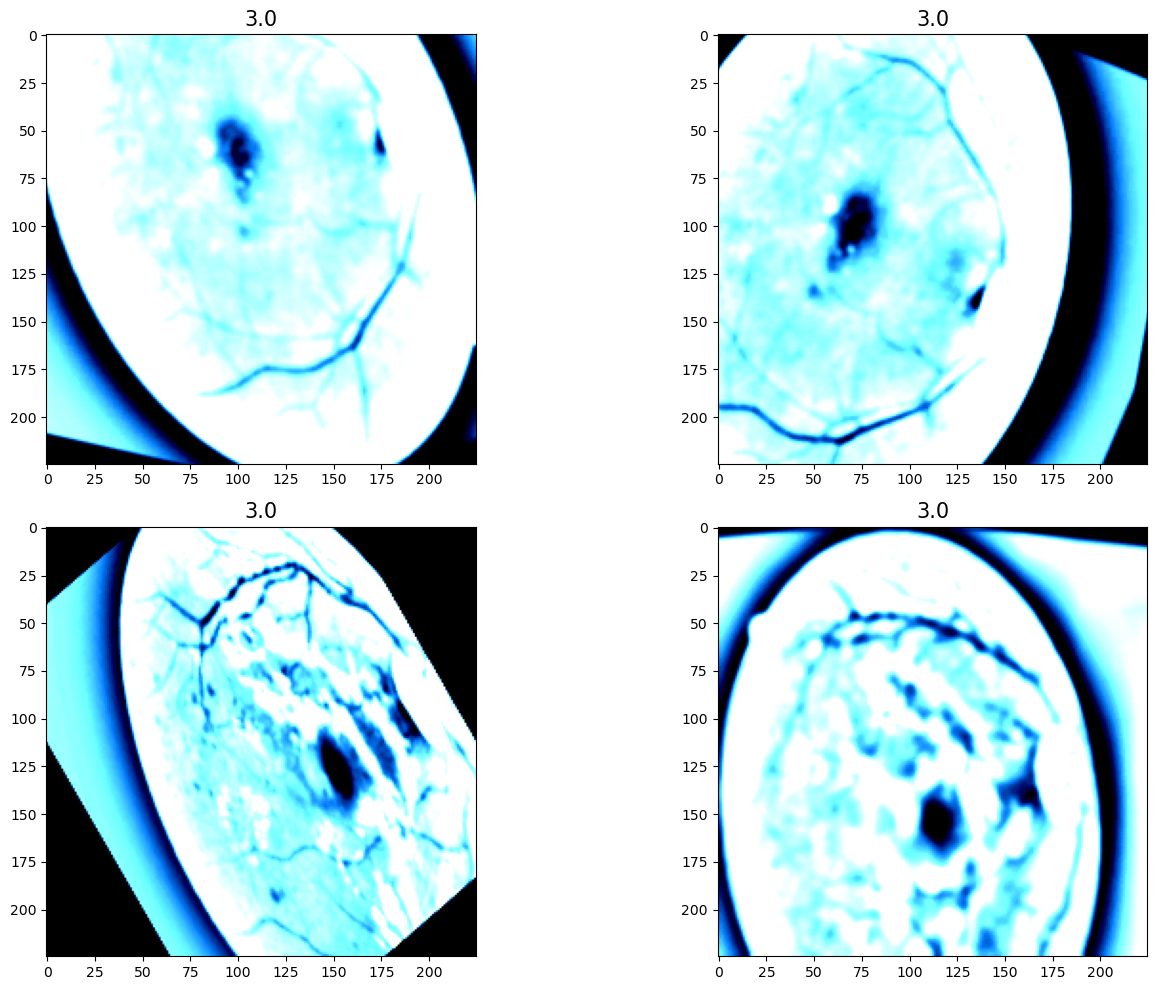

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(2):
    axs[i,0].imshow(dact['images']['img1'][i].numpy().transpose((1,2,0)))
    axs[i,1].imshow(dact['images']['img2'][i].numpy().transpose((1,2,0)))
    axs[i,0].set_title(f"{dact['labels']['label1'][i].item()}", size=15)
    axs[i,1].set_title(f"{dact['labels']['label2'][i].item()}", size=15)

plt.tight_layout()
plt.show()
    

In [23]:
del train_dataset, val_dataset, test_dataset, dact
del merged_df, trainval_df, train_test_merged, train_valid_merged

#### hyperparameters

In [24]:
def set_seed(seed : int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### convolutional neural network

In [25]:
def get_accuracy(predictions, labels):

    predictions[predictions < 0.5] = 0
    predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
    predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
    predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
    predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
    predictions = predictions.long().view(-1)
#     labels = labels.view(-1)

    num_correct = (predictions == labels).sum()
    num_samples = predictions.shape[0]
        
    return num_correct, num_samples

In [26]:
def predict_image(model:nn.Module, loader:DataLoader) -> None:
    model.eval()
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    
    num_images = 3
    image_count = 0
    
    for dict_data in loader:
        images, labels = dict_data['images'], dict_data['labels']
        for img in images:
            images[img] = images[img].to(device)
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
        
        with torch.no_grad():
            predictions = model(images)
            
            for i in range(predictions.shape[0]):
                # Convert MSE floats to integer predictions
                predictions[predictions < 0.5] = 0
                predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
                predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
                predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
                predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
                predictions = predictions.long().squeeze(1)

                if image_count < num_images:
                    
                    image = images['img1'][i].permute(1, 2, 0).cpu().numpy()
                    true_label1 = label1[i].item()
                    true_label2 = label2[i].item()
                    predicted_label1 = predictions[i][0].item()
                    predicted_label2 = predictions[i][1].item()
                    
                    axs[image_count].imshow(image)
                    axs[image_count].set_title(f'True: ({true_label1}), Predicted: ({predicted_label1})')
                    axs[image_count].axis('off')

                    image_count += 1
                else:
                    break
        
        if image_count >= num_images:
            break
    
    plt.show()
    
    


In [27]:
def make_prediction(model, loader):
    preds = []
    model.eval()

    for dict_data in tqdm(loader):
        images, labels = dict_data['images'], dict_data['labels']
        for img in images:
            images[img] = images[img].to(device)
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)

        with torch.no_grad():
            predictions = model(images)
            # Convert MSE floats to integer predictions
            predictions[predictions < 0.5] = 0
            predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
            predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
            predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
            predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
            predictions = predictions.long().squeeze(1)
            preds.append(predictions.cpu().numpy())

    return preds
    print("Done with predictions")


In [28]:
def check_accuracy(loader, model):
    model.eval()
    all_preds, all_labels = [], []
    num_correct = 0
    num_samples = 0

    for dict_data in tqdm(loader):
        images, labels = dict_data['images'], dict_data['labels']
        for img in images:
            images[img] = images[img].to(device)
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
        y = torch.dstack([label1,label2])

        with torch.no_grad():
            predictions = model(images)
            # Convert MSE floats to integer predictions
        predictions[predictions < 0.5] = 0
        predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
        predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
        predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
        predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
        predictions = predictions.long().view(-1)
        y = y.view(-1)

        num_correct += (predictions == y).sum()
        num_samples += predictions.shape[0]

        # add to lists
        all_preds.append(predictions.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
        
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)


In [29]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
    return model

In [30]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, train_dl: DataLoader,val_dl: DataLoader,
                num_epochs: int = 10) -> Tuple[nn.Module, List[float], List[float]]:  
    """
    Train a model on a dataset.

    Args:
      model: The model to train.
      criterion: The loss function.
      optimizer: The optimizer.
      scheduler: The learning_rate scheduler
      train_dl: The training dataloader.
      val_dl: The validation dataloader.
      num_epochs: The number of epochs to train for.

    Returns:
      A list of three elements. The first element is the model, the second element is a list of training losses, and the third element is a list of validation losses.
    """

    best_loss = 3.0
    train_loss = []
    val_loss = []
    patience = 5
    counter = 0

    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training Phase
        ns_T = 0
        ns_V = 0
        running_corrects_T = 0
        running_corrects_V = 0
        running_loss_T = 0.0
        running_loss_V = 0.0


        for batch_idx, dict_data in tqdm(enumerate(train_dl), total = len(train_dl)):
            #get data to cuda if possible
            model.train()
            images, labels = dict_data['images'], dict_data['labels']
            for img in images:
                images[img] = images[img].to(device)
            label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
            y = torch.dstack([label1,label2]).view(-1).float()

            # forward pass
            optimizer.zero_grad()
            scores = model(images).view(-1)
            loss = criterion(scores, y)
            loss.backward()
            nc, ns = get_accuracy(scores, y)
            ns_T += ns
            running_corrects_T += nc
            running_loss_T += loss.item() * images['img1'].size(0)
            train_loss.append(loss.item())

            #back propagation

            # gradient descent
            optimizer.step()


        # Validation Phase
        model.eval()
        
        with torch.no_grad():
            
            for batch_idx, dict_data in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
                images, labels = dict_data['images'], dict_data['labels']
                for img in images:
                    images[img] = images[img].to(device)
                label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
                y = torch.dstack([label1,label2]).view(-1).float()
                optimizer.zero_grad()
                scores = model(images).view(-1)
                loss = criterion(scores, y)
                nc, ns = get_accuracy(scores, y)
                ns_V += ns
                running_corrects_V += nc
                running_loss_V += loss.item() * images['img1'].size(0)
                val_loss.append(loss.item())
    
        Train_loss = running_loss_T / len(train_dataloader.dataset)
        Valid_loss = running_loss_V / len(val_dataloader.dataset)
        Train_acc = running_corrects_T.double() / ns_T
        Valid_acc = running_corrects_V.double() / ns_V
        scheduler.step(Valid_loss)
    
        print(f'Train Loss: {Train_loss:.4f} Train Acc: {Train_acc:.4f} Valid Loss: {Valid_loss:.4f} Valid Acc: {Valid_acc:.4f}')
    
        if Valid_loss < best_loss:
            best_loss = Valid_loss
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            save_checkpoint(checkpoint, filename=f"model_DR_{epoch}.pth.tar")
            predict_image(model, val_dataloader)
            
    return model, train_loss, val_loss

In [31]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BasicConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,stride=stride,padding=padding,bias=bias)
        self.norm = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self,x):
        x = self.conv1(x)
        x = self.norm(x)
        return x



class BottleNeck(nn.Module):
    def __init__(self, prev_channels, in_channels, out_channels, kernel_size=3, stride=2, padding=1, reduce=False):
        super(BottleNeck, self).__init__()
        self.reduce = reduce

        self.ReduceBlock1 = BasicConv2d(prev_channels, in_channels, kernel_size=1, stride=stride, padding=0)
        self.ReduceBlock2 = BasicConv2d(prev_channels, out_channels, kernel_size=1, stride=stride, padding=0)

        self.Block1 = BasicConv2d(prev_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.Block2 = BasicConv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.Block3 = BasicConv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = x
        if self.reduce:
            out = self.ReduceBlock1(x)
            out = self.relu(out)
            identity = self.ReduceBlock2(x)
        else:
            out = self.Block1(out)
            out = self.relu(out)
        out = self.Block2(out)
        out = self.relu(out)
        out = self.Block3(out)
        if self.reduce:
            out = self.relu(out+identity)
        
        return out



In [32]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, num_classes: int=1) -> nn.Module:
        super(ConvolutionNeuralNetwork, self).__init__()
        self.conv1 = BasicConv2d(3, 64, 7, 2, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)

        self.ResBlock2a = BottleNeck(64, 64, 256, 3, 1, 1, reduce=True)
        self.ResBlock2b = BottleNeck(256, 64, 256, 3)
        self.ResBlock2c = BottleNeck(256, 64, 256, 3)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.reg_model = nn.Sequential(
            nn.BatchNorm1d(256* 2),
            nn.Linear((256) * 2, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 2),
        )
        
    def forward(self, images):
        img = self.conv1(images['img1'])
        img = self.pool1(img)
        img = self.ResBlock2a(img)
        img = self.ResBlock2b(img)
        img = self.ResBlock2c(img)
        img = self.avgpool(img)
        img = torch.flatten(img, 1)
        
        img1= self.conv1(images['img2'])
        img1= self.pool1(img1)
        img1= self.ResBlock2a(img1)
        img1= self.ResBlock2b(img1)
        img1= self.ResBlock2c(img1)
        img1 = self.avgpool(img1)
        img1 = torch.flatten(img1, 1)
        
        conc = torch.cat((img, img1), dim=1)
        x = self.reg_model(conc)
        
        return x


In [33]:
model_cnn = ConvolutionNeuralNetwork().to(device)
learning_rate = 1e-4
NUM_EPOCHS = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=2,verbose=True)

# CNNmodel, CNNtl, CNNvl = train_model(model_cnn, criterion, optimizer, scheduler, train_dataloader, val_dataloader)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix

## EfficientNet B3

In [40]:
class Efficient(nn.Module):
    def __init__(self, num_classes:int=1):
        super(Efficient, self).__init__()
        self.model = EfficientNet.from_pretrained("efficientnet-b3")
        num_features = self.model._fc.in_features
        self.model._fc = nn.Linear(num_features, 256)
        
        self.reg_model = nn.Sequential(
            nn.BatchNorm1d(256* 2),
            nn.Linear((256) * 2, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 2),
        )

    def forward(self, images):
        img1 = self.model(images['img1'])
        img2 = self.model(images['img2'])
        conc = torch.cat((img1,img2), dim=1)
        x = self.reg_model(conc)
        return x

In [41]:
model_eff = Efficient().to(device)
learning_rate = 1e-4
NUM_EPOCHS = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model_eff.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=2,verbose=True)

# EFFmodel, EFFtl, EFFvl = train_model(model_eff, criterion, optimizer, scheduler, train_dataloader, val_dataloader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 27.1MB/s]


Loaded pretrained weights for efficientnet-b3


In [44]:
# report = classification_report(labels, preds)
# print(report)

# CREATING THE ENSEMBLE MODEL

In [45]:
class EnsembleModel(nn.Module):
    def __init__(self, model_cnn, model_eff):
        super(EnsembleModel, self).__init__()
        self.model_cnn = model_cnn
        self.model_eff = model_eff
        assert model_cnn.reg_model[-1].out_features == model_eff.reg_model[-1].out_features
        # They both have same num_classes so we dont need to edit any code here for the fully connected layer
        
    def forward(self, images):
        model_cnn_output = self.model_cnn(images)
        model_res_output = self.model_eff(images)
        ensemble_output = (model_cnn_output + model_res_output) / 2.0
        # ensemble_output = torch.cat((model_cnn_output, model_res_output), dim=1)
        return ensemble_output

# ENSEMBLE TESTING

Epoch 0/9
----------


100%|██████████| 653/653 [04:13<00:00,  2.57it/s]


Train Loss: 1.5223 Train Acc: 0.4383 Valid Loss: 0.3616 Valid Acc: 0.6694
=> Saving checkpoint


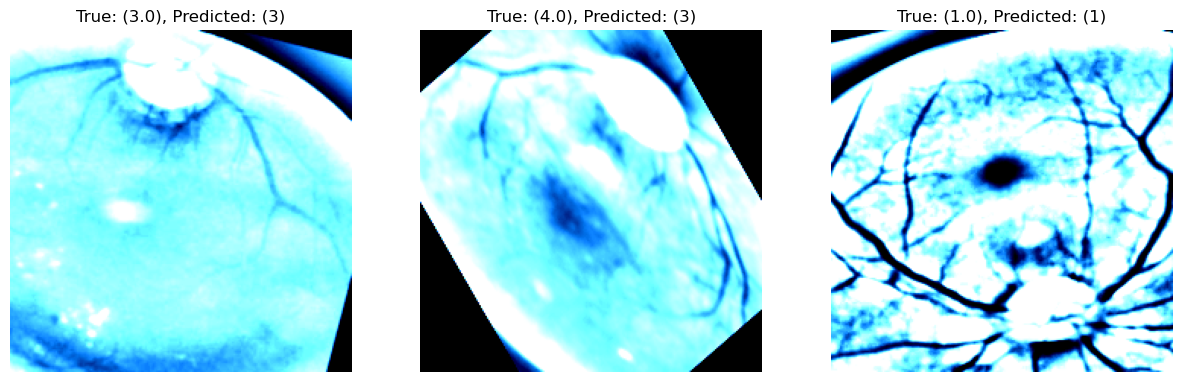

Epoch 1/9
----------


100%|██████████| 653/653 [04:10<00:00,  2.61it/s]


Train Loss: 0.3794 Train Acc: 0.6717 Valid Loss: 0.2216 Valid Acc: 0.8077
=> Saving checkpoint


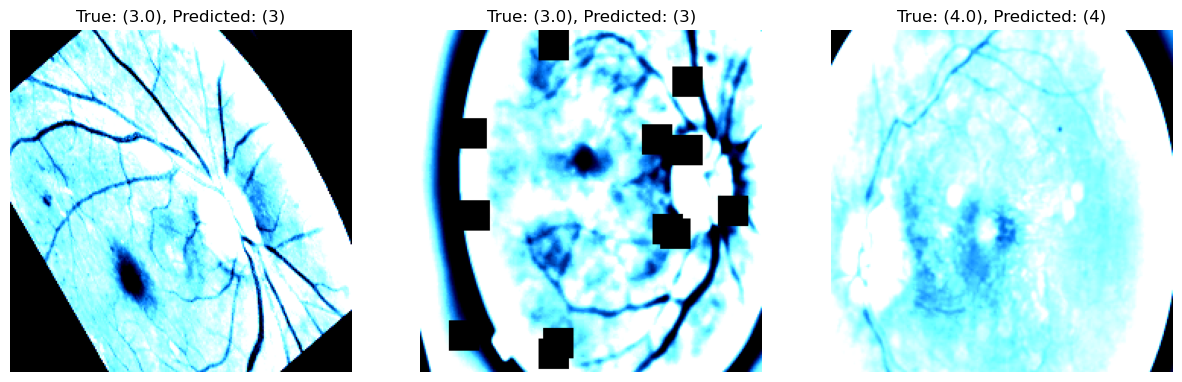

Epoch 2/9
----------


100%|██████████| 653/653 [04:12<00:00,  2.59it/s]


Train Loss: 0.2971 Train Acc: 0.7446 Valid Loss: 0.1609 Valid Acc: 0.8582
=> Saving checkpoint


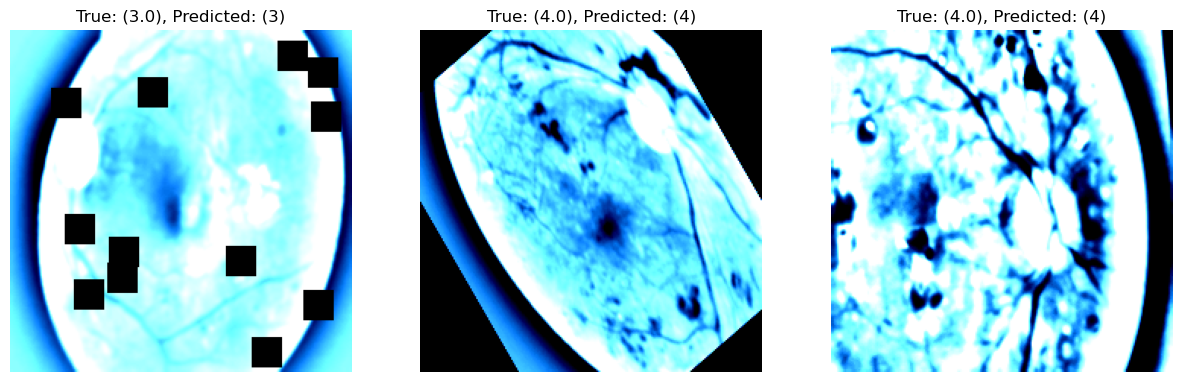

Epoch 3/9
----------


100%|██████████| 653/653 [04:09<00:00,  2.62it/s]


Train Loss: 0.2436 Train Acc: 0.7917 Valid Loss: 0.1398 Valid Acc: 0.8836
=> Saving checkpoint


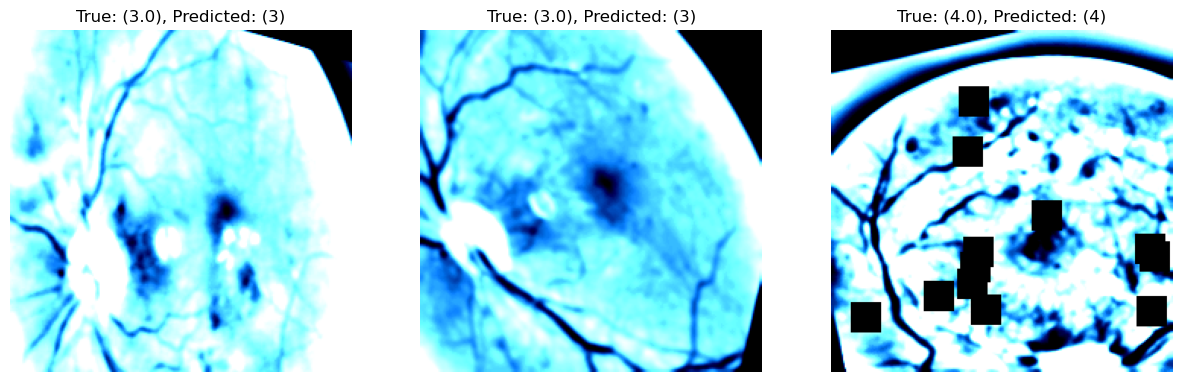

Epoch 4/9
----------


100%|██████████| 653/653 [04:14<00:00,  2.57it/s]

Train Loss: 0.2028 Train Acc: 0.8277 Valid Loss: 0.1406 Valid Acc: 0.8934
Epoch 5/9
----------



100%|██████████| 653/653 [04:11<00:00,  2.60it/s]


Train Loss: 0.1752 Train Acc: 0.8534 Valid Loss: 0.1032 Valid Acc: 0.9101
=> Saving checkpoint


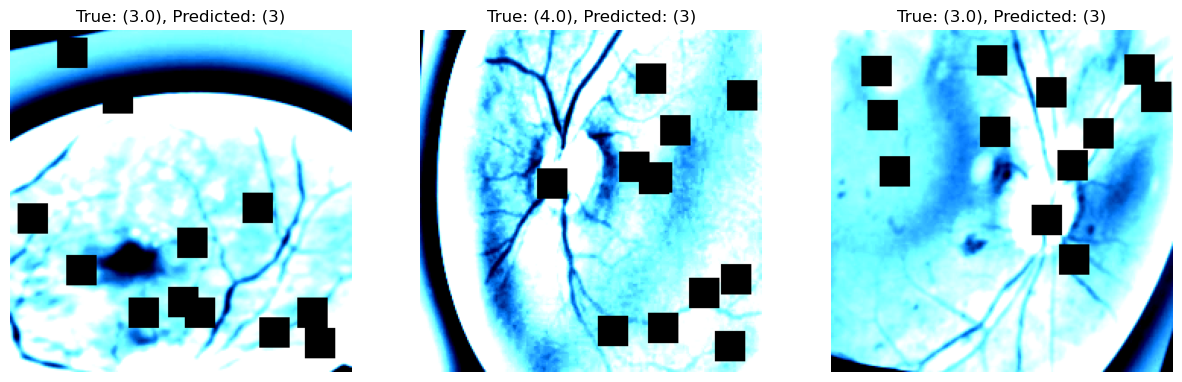

Epoch 6/9
----------


100%|██████████| 653/653 [04:14<00:00,  2.56it/s]


Train Loss: 0.1555 Train Acc: 0.8711 Valid Loss: 0.0963 Valid Acc: 0.9136
=> Saving checkpoint


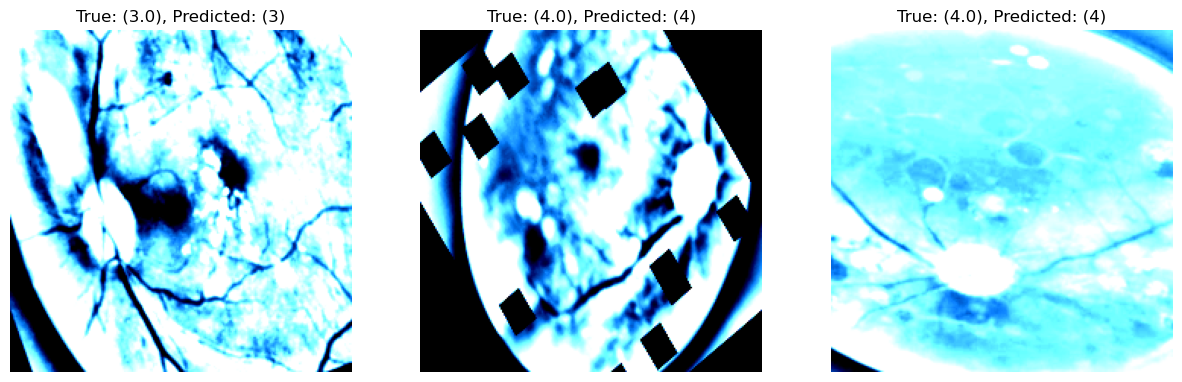

Epoch 7/9
----------


100%|██████████| 653/653 [04:29<00:00,  2.42it/s]


Train Loss: 0.1425 Train Acc: 0.8825 Valid Loss: 0.0856 Valid Acc: 0.9214
=> Saving checkpoint


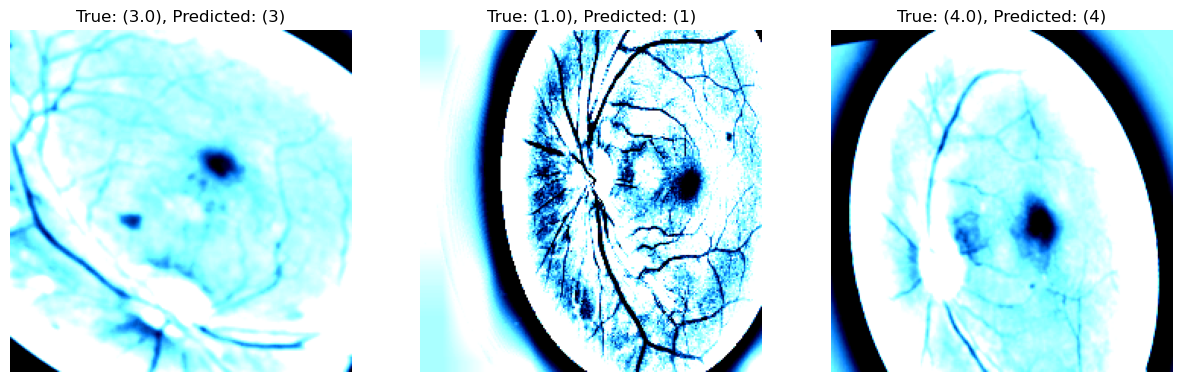

Epoch 8/9
----------


100%|██████████| 653/653 [04:18<00:00,  2.53it/s]


Train Loss: 0.1322 Train Acc: 0.8918 Valid Loss: 0.0791 Valid Acc: 0.9285
=> Saving checkpoint


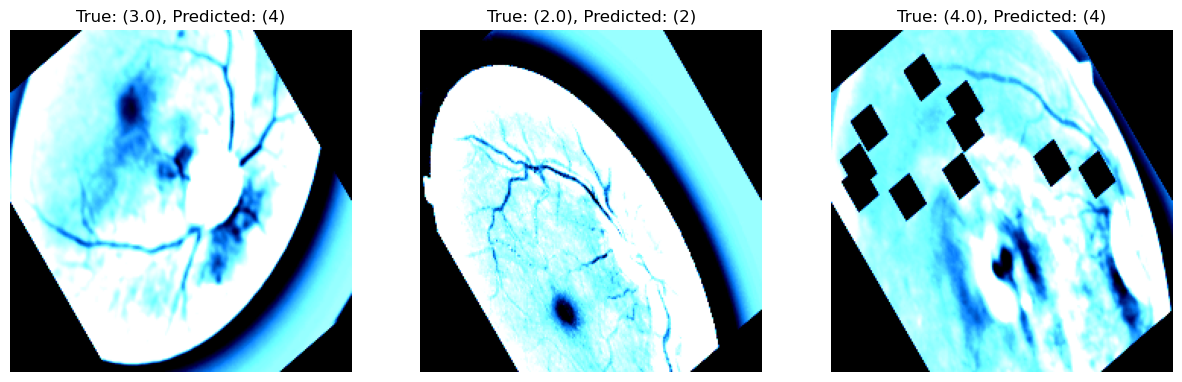

Epoch 9/9
----------


100%|██████████| 653/653 [04:21<00:00,  2.50it/s]


Train Loss: 0.1208 Train Acc: 0.9016 Valid Loss: 0.0769 Valid Acc: 0.9321
=> Saving checkpoint


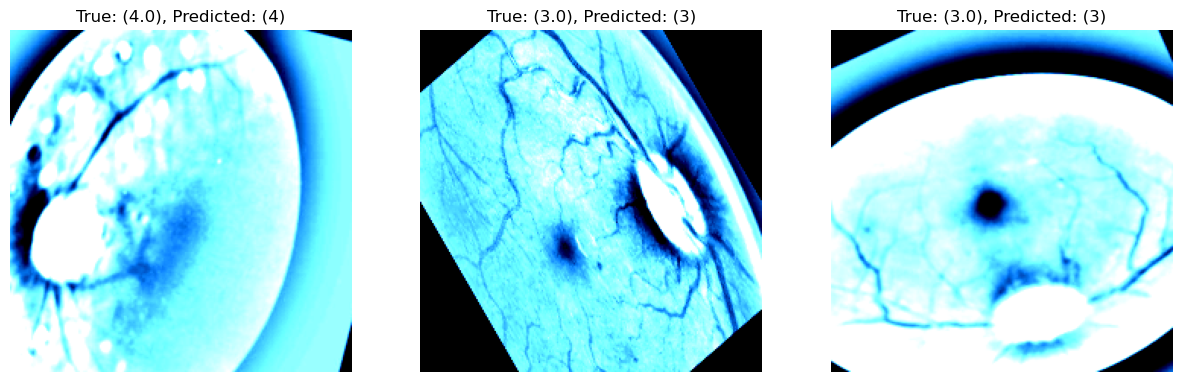

In [46]:
model_ensemble = EnsembleModel(model_cnn, model_eff).to(device)
learning_rate = 1e-4
NUM_EPOCHS = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model_ensemble.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=2,verbose=True)

ENSmodel, ENStl, ENSvl = train_model(model_ensemble, criterion, optimizer, scheduler, train_dataloader, val_dataloader)

### Checking other evaluation metrics

In [47]:
preds, labels = check_accuracy(test_dataloader, ENSmodel)

100%|██████████| 363/363 [02:33<00:00,  2.36it/s]

Got 21915 / 23206 with accuracy 94.44


In [48]:
print(f"QuadraticWeightedKappa (Test): {cohen_kappa_score(labels, preds, weights='quadratic')}")

QuadraticWeightedKappa (Test): 0.969682605573651


In [49]:
report = classification_report(labels, preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       337
         1.0       0.74      0.95      0.83      2252
         2.0       0.77      0.52      0.62      1438
         3.0       0.97      0.99      0.98      8516
         4.0       1.00      1.00      1.00     10663

    accuracy                           0.94     23206
   macro avg       0.69      0.69      0.69     23206
weighted avg       0.93      0.94      0.94     23206



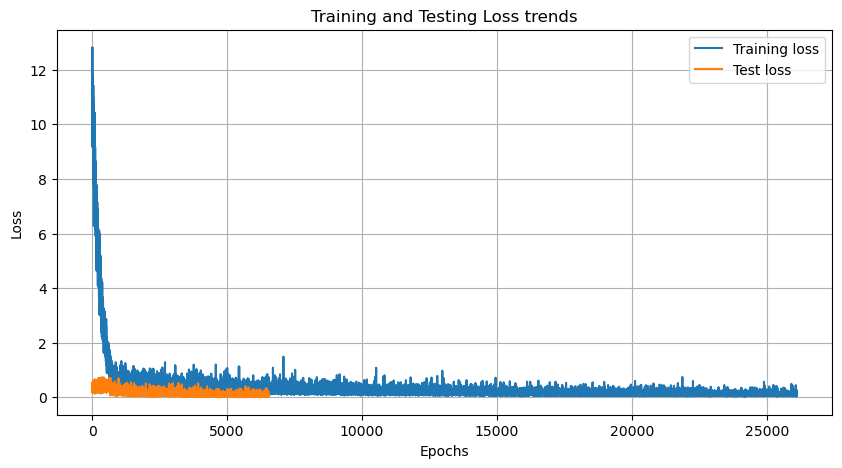

In [50]:
# plotting the epoch-to-train and test trend
plt.figure(figsize = (10, 5))
plt.plot(ENStl, label = "Training loss")
plt.plot(ENSvl, label = "Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss trends")
plt.legend()
plt.grid(True)
plt.show()